**Power Supply Demand**

**Objective:**

The goal of this project is to understand and forecast hourly electricity consumption in the PJM Interconnection region. PJM operates one of the largest electricity grids in the United States, and accurate demand forecasting is critical for grid reliability, cost optimization, and planning.

**Purpose of the Project:**

1.To analyze how electricity is used every hour in the PJM region.

2.To find patterns in energy use during different hours, days, seasons, and holidays.

3.To clean and prepare the data by handling missing values, outliers, and duplicates.

4.To break the data into trend, seasonal, and random parts using ETS decomposition.

5.To understand how energy demand changes over time.

6.To build a model that can predict energy usage for the next 30 days.

7.To help electricity providers plan better and avoid shortages or waste.

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df=pd.read_csv("PJMW_hourly.csv")

In [132]:
df

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0
...,...,...
143201,2018-01-01 20:00:00,8401.0
143202,2018-01-01 21:00:00,8373.0
143203,2018-01-01 22:00:00,8238.0
143204,2018-01-01 23:00:00,7958.0


In [133]:
df.columns

Index(['Datetime', 'PJMW_MW'], dtype='object')

In [134]:
df.shape

(143206, 2)

In [135]:
df.describe()

,PJMW_MW
count,143206.000000
mean,5602.375089
std,979.142872
min,487.000000
25%,4907.000000
50%,5530.000000
75%,6252.000000
max,9594.000000


**Data Consistency**

In [137]:
# Convert time column to datetime
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [138]:
df['Datetime']

0        2002-12-31 01:00:00
1        2002-12-31 02:00:00
2        2002-12-31 03:00:00
3        2002-12-31 04:00:00
4        2002-12-31 05:00:00
                 ...        
143201   2018-01-01 20:00:00
143202   2018-01-01 21:00:00
143203   2018-01-01 22:00:00
143204   2018-01-01 23:00:00
143205   2018-01-02 00:00:00
Name: Datetime, Length: 143206, dtype: datetime64[ns]

In [139]:
# Set datetime as index
df.set_index('Datetime', inplace=True)

In [140]:
# Drop duplicate timestamps
df = df[~df.index.duplicated(keep='first')]


In [141]:
# Recreate derived columns safely
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month

# Check
print("✅ Final shape after removing index duplicates:", df.shape)
print("⛔ Remaining duplicated index values:", df.index.duplicated().sum())

✅ Final shape after removing index duplicates: (143202, 4)
⛔ Remaining duplicated index values: 0


C:\Users\mukes\AppData\Local\Temp\ipykernel_12764\1331039434.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
C:\Users\mukes\AppData\Local\Temp\ipykernel_12764\1331039434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
C:\Users\mukes\AppData\Local\Temp\ipykernel_12764\1331039434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [142]:
df

,PJMW_MW,hour,dayofweek,month
Datetime,,,,
2002-12-31 01:00:00,5077.0,1,1,12
2002-12-31 02:00:00,4939.0,2,1,12
2002-12-31 03:00:00,4885.0,3,1,12
2002-12-31 04:00:00,4857.0,4,1,12
2002-12-31 05:00:00,4930.0,5,1,12
...,...,...,...,...
2018-01-01 20:00:00,8401.0,20,0,1
2018-01-01 21:00:00,8373.0,21,0,1
2018-01-01 22:00:00,8238.0,22,0,1


In [143]:
# Enforce consistent hourly frequency
df = df.asfreq('H')

C:\Users\mukes\AppData\Local\Temp\ipykernel_12764\2799777932.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq('H')


**Fill Missing Values**

In [145]:
# Forward and backward fill
df['PJMW_MW'] = df['PJMW_MW'].ffill().bfill()

In [146]:
df['PJMW_MW']

Datetime
2002-04-01 01:00:00    4374.0
2002-04-01 02:00:00    4306.0
2002-04-01 03:00:00    4322.0
2002-04-01 04:00:00    4359.0
2002-04-01 05:00:00    4436.0
                        ...  
2018-08-02 20:00:00    6545.0
2018-08-02 21:00:00    6496.0
2018-08-02 22:00:00    6325.0
2018-08-02 23:00:00    5892.0
2018-08-03 00:00:00    5489.0
Freq: h, Name: PJMW_MW, Length: 143232, dtype: float64

# Visualize The Original Data

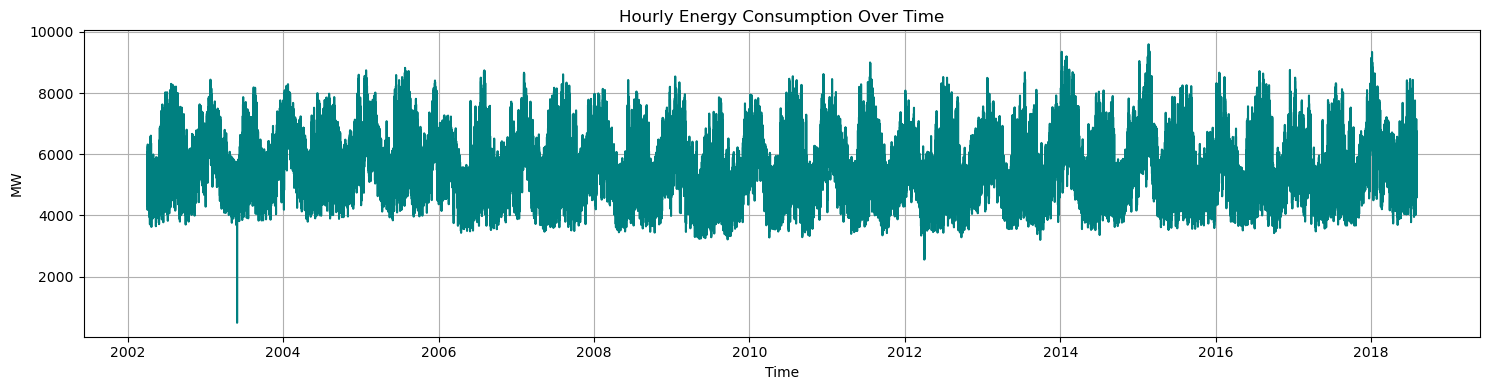

In [148]:
plt.figure(figsize=(15, 4))
plt.plot(df['PJMW_MW'], color='teal')
plt.title("Hourly Energy Consumption Over Time")
plt.xlabel("Time")
plt.ylabel("MW")
plt.grid(True)
plt.tight_layout()
plt.show()


This plot reveals a clear cyclical pattern, with daily and seasonal fluctuations. You can also spot some sharp drops or spikes, likely due to holidays or outages. The overall trend is stable with high-frequency variability.

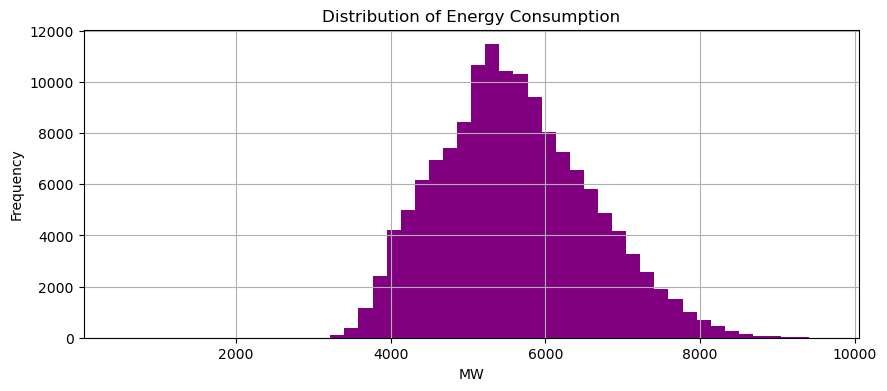

In [150]:
df['PJMW_MW'].hist(bins=50, figsize=(10, 4), color='purple')
plt.title("Distribution of Energy Consumption")
plt.xlabel("MW")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

Most of the energy usage is concentrated between 25000 MW and 40000 MW. There's a slight right skew, indicating a few instances of very high consumption, likely during extreme weather events.

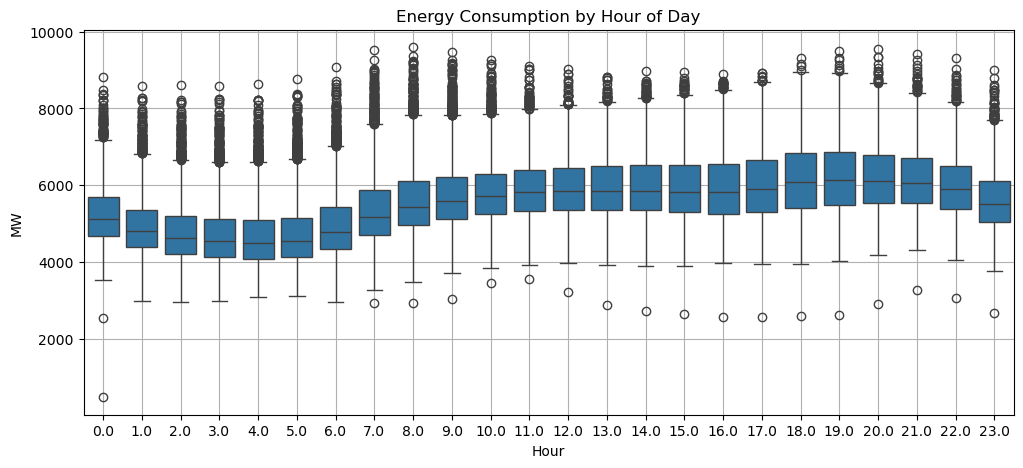

In [152]:
import seaborn as sns

plt.figure(figsize=(12, 5))
sns.boxplot(x='hour', y='PJMW_MW', data=df)
plt.title("Energy Consumption by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("MW")
plt.grid(True)
plt.show()

**Detect and Treat Outliers**

In [154]:
# IQR method
Q1 = df['PJMW_MW'].quantile(0.25)
Q3 = df['PJMW_MW'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [155]:
lower_bound,upper_bound

(2887.0, 8271.0)

In [156]:
# Mark outliers
outliers = (df['PJMW_MW'] < lower_bound) | (df['PJMW_MW'] > upper_bound)

In [157]:
outliers

Datetime
2002-04-01 01:00:00    False
2002-04-01 02:00:00    False
2002-04-01 03:00:00    False
2002-04-01 04:00:00    False
2002-04-01 05:00:00    False
                       ...  
2018-08-02 20:00:00    False
2018-08-02 21:00:00    False
2018-08-02 22:00:00    False
2018-08-02 23:00:00    False
2018-08-03 00:00:00    False
Freq: h, Name: PJMW_MW, Length: 143232, dtype: bool

In [158]:
# Replace outliers with NaN
df.loc[outliers, 'PJMW_MW'] = np.nan

In [159]:
df.loc[outliers, 'PJMW_MW']

Datetime
2002-07-22 17:00:00   NaN
2003-01-23 18:00:00   NaN
2003-01-23 19:00:00   NaN
2003-01-23 20:00:00   NaN
2003-01-23 21:00:00   NaN
                       ..
2018-07-03 19:00:00   NaN
2018-07-16 15:00:00   NaN
2018-07-16 16:00:00   NaN
2018-07-16 17:00:00   NaN
2018-07-16 18:00:00   NaN
Name: PJMW_MW, Length: 699, dtype: float64

In [160]:
# Fill outliers via time-based interpolation
df['PJMW_MW'] = df['PJMW_MW'].interpolate(method='time')

In [161]:
df['PJMW_MW']

Datetime
2002-04-01 01:00:00    4374.0
2002-04-01 02:00:00    4306.0
2002-04-01 03:00:00    4322.0
2002-04-01 04:00:00    4359.0
2002-04-01 05:00:00    4436.0
                        ...  
2018-08-02 20:00:00    6545.0
2018-08-02 21:00:00    6496.0
2018-08-02 22:00:00    6325.0
2018-08-02 23:00:00    5892.0
2018-08-03 00:00:00    5489.0
Freq: h, Name: PJMW_MW, Length: 143232, dtype: float64

**Check for Duplicates (again, post-cleanup)**

In [163]:
# Confirm no duplicates remain
duplicate_count = df.index.duplicated().sum()
print(f"Remaining duplicates in datetime index: {duplicate_count}")

Remaining duplicates in datetime index: 0


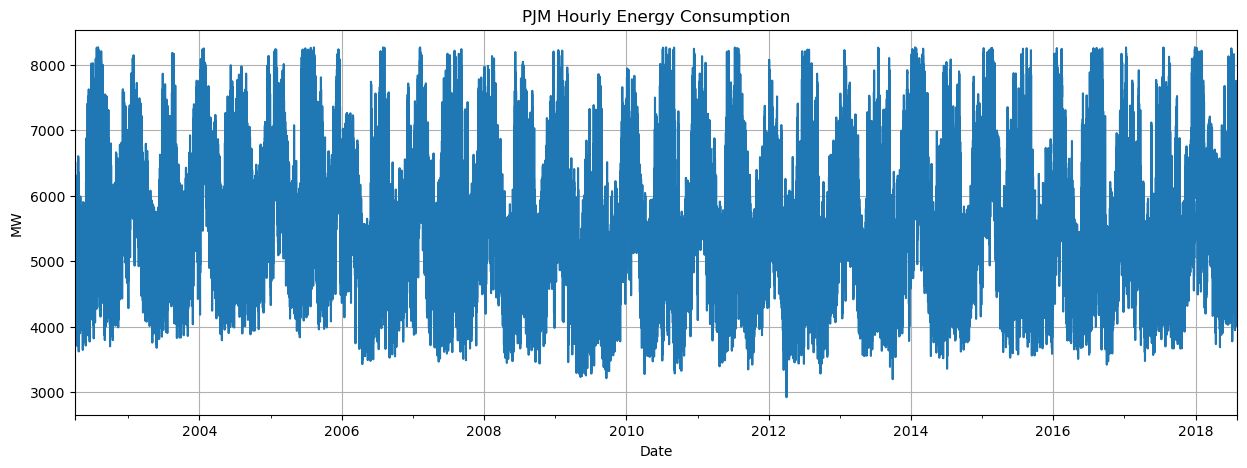

In [164]:
# Visualize original data
plt.figure(figsize=(15, 5))
df['PJMW_MW'].plot(title='PJM Hourly Energy Consumption')
plt.xlabel('Date')
plt.ylabel('MW')
plt.grid()
plt.show()

**ETS Decomposition Using STL**

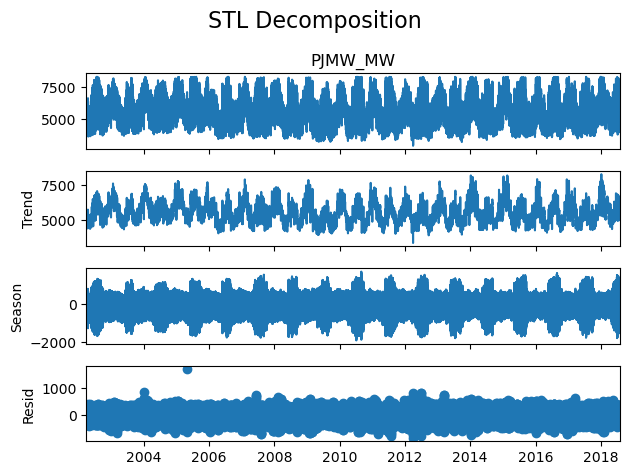

In [167]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
stl = STL(df['PJMW_MW'], period=24)
result = stl.fit()

result.plot()
plt.suptitle('STL Decomposition', fontsize=16)
plt.tight_layout()
plt.show()

**Top Plot** – Original Time Series (PJM_MW)

This is the raw data of electricity demand over time.

You can see high-frequency fluctuations, indicating daily and weekly changes in demand.

**Second Plot** – Trend

Shows the long-term direction in the data.

Here, demand seems to rise and fall gradually over time, capturing broader patterns.

**Third Plot** – Seasonality

Shows repeating patterns at fixed intervals.

In this case, it's likely showing daily or weekly cycles (since period=24, i.e., hourly data over 24 hours = daily seasonality).

For example, demand might rise during the day and fall at night.

**Bottom Plot** – Residual (Noise)

This is what's left after removing trend and seasonality.

It represents random variations or unexpected spikes/drops in demand.

STL splits time series into trend, seasonal, and residual parts.

period=24 assumes daily seasonality (24 hours in a day).






In [170]:
import warnings
warnings.filterwarnings("ignore")

**Test for Stationarity (ADF Test)**

In [172]:
adf_result = adfuller(df['PJMW_MW'])

print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
if adf_result[1] < 0.05:
    print("Data is stationary")
else:
    print("Data is not stationary")

ADF Statistic: -19.95515645745867
p-value: 0.0
Data is stationary


The ADF test checks whether the data is stationary (important for ARIMA).

If p-value < 0.05, the data is stationary.

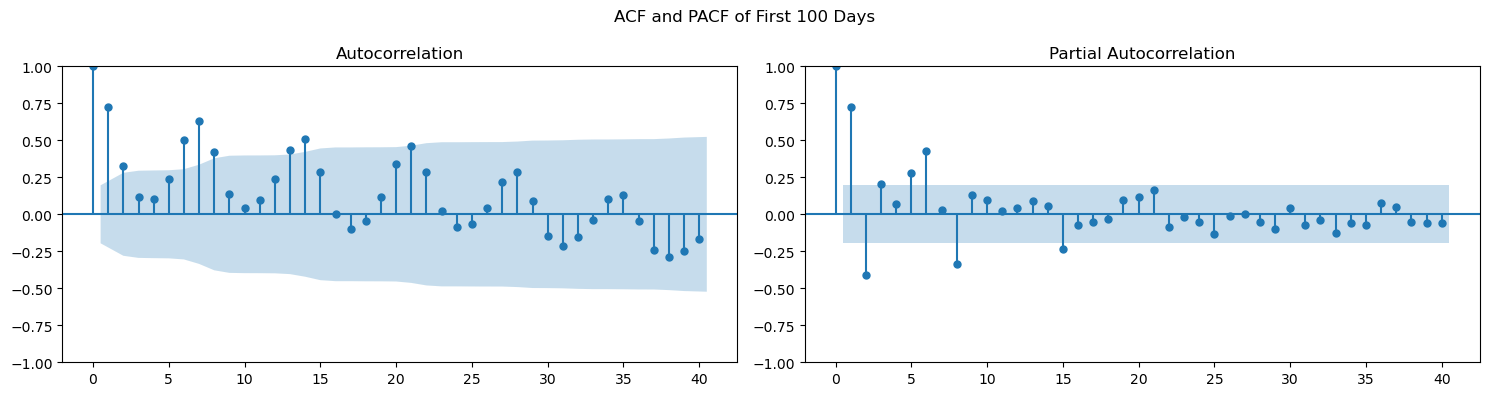

In [174]:
daily_df = df.resample('D').mean()
daily_first_100 = daily_df.head(100)

# Plot ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(daily_first_100['PJMW_MW'], lags=40, ax=axes[0])
plot_pacf(daily_first_100['PJMW_MW'], lags=40, ax=axes[1])
plt.suptitle("ACF and PACF of First 100 Days")
plt.tight_layout()
plt.show()

lags=40 means checking autocorrelation up to 40 previous time points.

ax=axes[0] plots it on the left subplot.

ax=axes[1] places it on the right subplot.

Changes data from hourly to daily using average.

Take the first 100 days — used for plotting ACF and PACF.

Shows autocorrelation and partial autocorrelation — helps determine lag values for ARIMA/SARIMA.




**Methods for Model Building**

1. Prophet (by Facebook)

Type: Additive model with trend + seasonality + holiday

Best for: Daily or weekly data, seasonality, trend shifts

Handles: Missing data, outliers, holidays

Example: Forecast next 30 days using daily energy usage

2.ARIMA (AutoRegressive Integrated Moving Average)

Type: Classical statistical model

Best for: Short-term forecasting on stationary data

Handles: No trend or simple trends

Limitation: Doesn’t model seasonality well unless extended

3.SARIMA (Seasonal ARIMA)

Type: ARIMA + Seasonal Component

Best for: Time series with seasonal patterns (e.g., daily/weekly/yearly)

Handles: Trend + seasonality

Example: Energy usage that follows a yearly summer/winter pattern

4.LSTM (Long Short-Term Memory Neural Network)

Type: Deep learning (RNN)

Best for: Nonlinear, long-term patterns

Handles: Large datasets, multiple input features (e.g., temperature, holidays)

Limitation: Slower, needs more data and tuning

5.XGBoost / LightGBM (Boosted Trees)

Type: Machine Learning (Gradient Boosting)

Best for: Tabular time series + multiple features (like weather, hour, holiday)

Handles: High accuracy for short-term forecasting

Need: Feature engineering (lags, hour, dayofweek, etc.)

6.ETS (Exponential Smoothing: Holt-Winters)

Type: Smoothing-based statistical method

Best for: Trend + seasonality when simplicity is key

Handles: Level + trend + seasonality

**Create Lagged Features (Using Best Lags from ACF/PACF)**

In [179]:
df_lag = daily_df.copy()
df_lag['lag1'] = df_lag['PJMW_MW'].shift(1)
df_lag['lag2'] = df_lag['PJMW_MW'].shift(2)
df_lag['lag7'] = df_lag['PJMW_MW'].shift(7)
df_lag.dropna(inplace=True)

Creates lagged features: yesterday (lag1), 2 days ago (lag2), 7 days ago (lag7).

Useful for Random Forest and deep learning models.

**Exponential Smoothing (Holt-Winters)**

In [182]:
train_size = int(len(df_lag) * 0.8)
train, test = df_lag.iloc[:train_size], df_lag.iloc[train_size:]

model_es = ExponentialSmoothing(train['PJMW_MW'], trend='add', seasonal='add', seasonal_periods=7)
fitted_es = model_es.fit()
pred_es = fitted_es.forecast(len(test))

Fits an Exponential Smoothing model that captures trend and seasonality.

seasonal_periods=7 → weekly pattern.



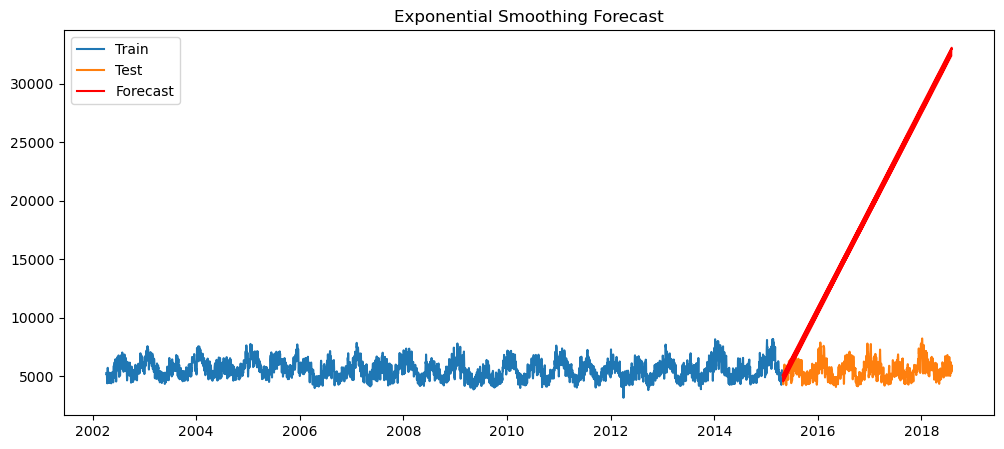

In [184]:
# Plot
plt.figure(figsize=(12, 5))
plt.plot(train.index, train['PJMW_MW'], label='Train')
plt.plot(test.index, test['PJMW_MW'], label='Test')
plt.plot(test.index, pred_es, label='Forecast', color='red')
plt.title('Exponential Smoothing Forecast')
plt.legend()
plt.show()

In [185]:
# RMSE
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
rmse_es = np.sqrt(mean_squared_error(test['PJMW_MW'], pred_es))
print(f"RMSE (Exponential Smoothing): {rmse_es:.2f}")

RMSE (Exponential Smoothing): 15578.52


**ARIMA Model**

In [187]:
# Determine order manually or use auto_arima (optional)
model_arima = ARIMA(train['PJMW_MW'], order=(5,1,2))
fitted_arima = model_arima.fit()
pred_arima = fitted_arima.forecast(len(test))

Fits an ARIMA model:

5 lags (AR)- Look at the past 5 days of energy usage



1 difference (I)-Subtract today's value from yesterday's (to remove trend)


2 moving averages (MA)-Use last 2 forecast errors to improve prediction

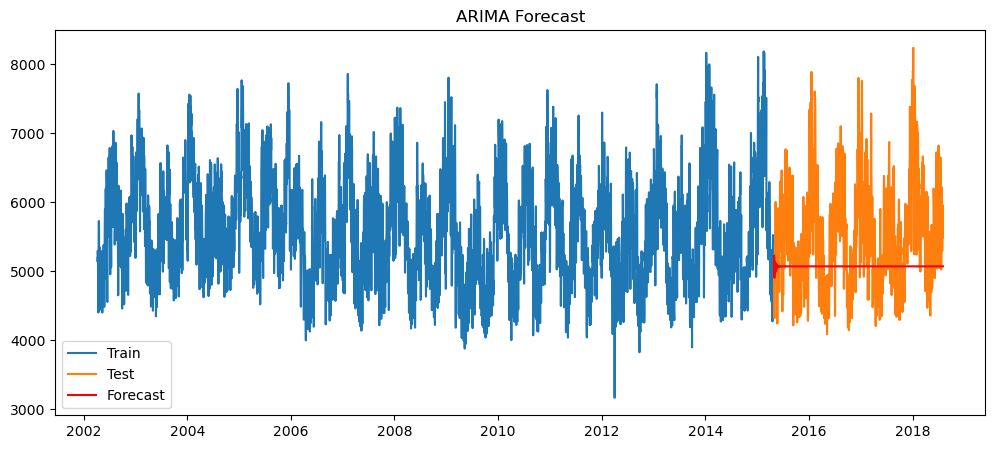

In [189]:
# Plot
plt.figure(figsize=(12, 5))
plt.plot(train.index, train['PJMW_MW'], label='Train')
plt.plot(test.index, test['PJMW_MW'], label='Test')
plt.plot(test.index, pred_arima, label='Forecast', color='red')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()


In [190]:
# RMSE
rmse_arima = np.sqrt(mean_squared_error(test['PJMW_MW'], pred_arima))
print(f"RMSE (ARIMA): {rmse_arima:.2f}")

RMSE (ARIMA): 873.00


**SARIMA (Seasonal ARIMA)**

In [192]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Using seasonal_order=(1,1,1,24) for daily seasonality
model_sarima = SARIMAX(train['PJMW_MW'], order=(2,1,2), seasonal_order=(1,1,1,7))
sarima_result = model_sarima.fit()

Like ARIMA but adds seasonal components.

Seasonal pattern = 7 days.



In [194]:
pred_sarima = sarima_result.forecast(len(test))

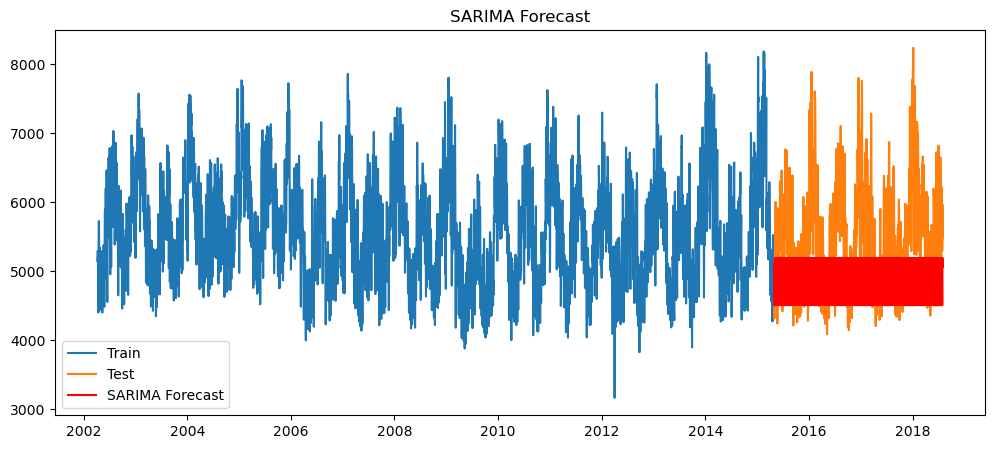

In [195]:
plt.figure(figsize=(12, 5))
plt.plot(train.index, train['PJMW_MW'], label='Train')
plt.plot(test.index, test['PJMW_MW'], label='Test')
plt.plot(test.index, pred_sarima, label='SARIMA Forecast', color='red')
plt.legend()
plt.title('SARIMA Forecast')
plt.show()

In [196]:
print(f"RMSE (SARIMA): {np.sqrt(mean_squared_error(test['PJMW_MW'], pred_sarima)):.2f}")


RMSE (SARIMA): 904.90


**Prophet (Meta/Facebook)**

In [198]:
from prophet import Prophet


In [199]:
# Prepare data for Prophet
df_prophet = daily_df.reset_index().rename(columns={"Datetime": "ds", "PJMW_MW": "y"})


In [200]:
# Train-test split
train_p = df_prophet.iloc[:train_size]
test_p = df_prophet.iloc[train_size:]

In [201]:
model_prophet = Prophet(daily_seasonality=True)
model_prophet.fit(train_p)

15:56:27 - cmdstanpy - INFO - Chain [1] start processing
15:56:29 - cmdstanpy - INFO - Chain [1] done processing


In [202]:
future = model_prophet.make_future_dataframe(periods=len(test_p))
forecast = model_prophet.predict(future)

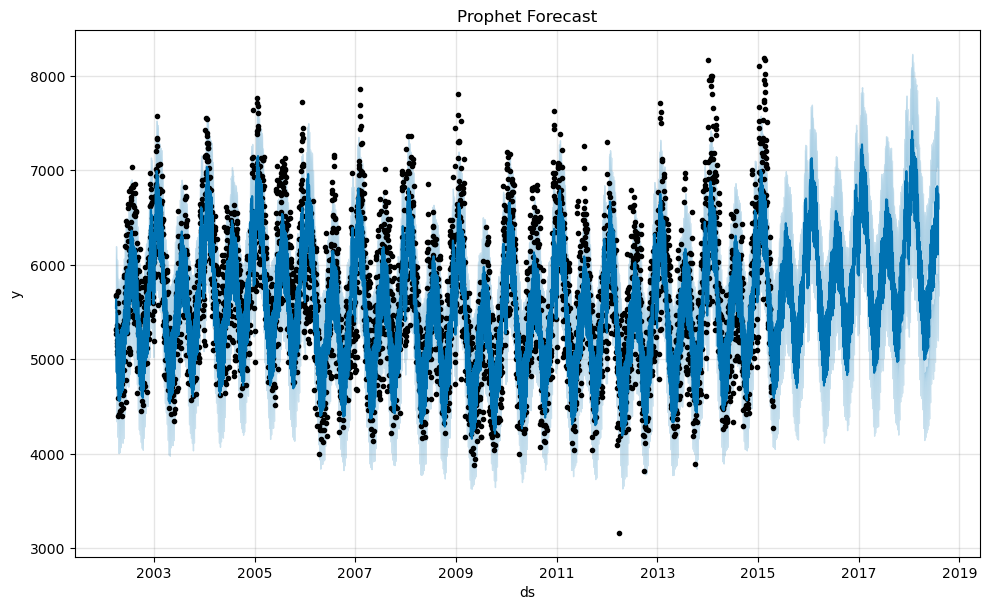

In [203]:
# Plot forecast
model_prophet.plot(forecast)
plt.title("Prophet Forecast")
plt.show()

In [204]:
# RMSE
y_true = test_p['y'].values
y_pred = forecast['yhat'].iloc[-len(test_p):].values
rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE (Prophet): {rmse_prophet:.2f}")

RMSE (Prophet): 708.91


**Random Forest Regressor (using lagged features)**

In [206]:
from sklearn.ensemble import RandomForestRegressor


In [207]:
# Add lagged features (1, 2, 7 days)
df_lag = daily_df.copy()
df_lag['lag1'] = df_lag['PJMW_MW'].shift(1)
df_lag['lag2'] = df_lag['PJMW_MW'].shift(2)
df_lag['lag7'] = df_lag['PJMW_MW'].shift(7)
df_lag.dropna(inplace=True)

Uses lag features as inputs.

Random Forest can handle non-linear patterns.


In [209]:
# Train-test
X = df_lag[['lag1', 'lag2', 'lag7']]
y = df_lag['PJMW_MW']
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [210]:
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

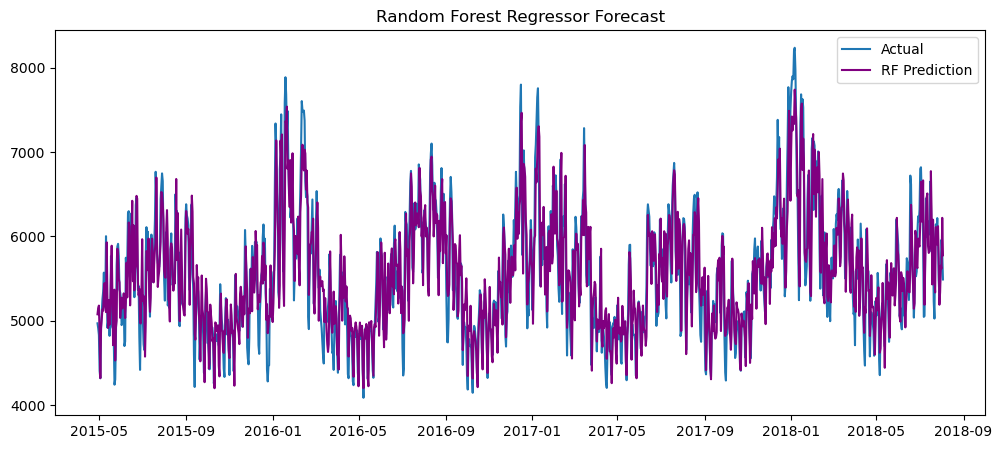

In [211]:
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_rf, label='RF Prediction', color='purple')
plt.legend()
plt.title("Random Forest Regressor Forecast")
plt.show()


In [212]:
print(f"RMSE (Random Forest): {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}")


RMSE (Random Forest): 371.67


**RMSE Comparison Table**

In [214]:
rmse_results = {
    "Exponential Smoothing": rmse_es,
    "ARIMA": rmse_arima,
    "SARIMA": np.sqrt(mean_squared_error(test['PJMW_MW'], pred_sarima)),
    "Prophet": rmse_prophet,
    "Random Forest": np.sqrt(mean_squared_error(y_test, y_pred_rf)),

}


In [215]:
# Print as table
print("\n RMSE Comparison Table:")
for model, score in rmse_results.items():
    print(f"{model:25s}: {score:.2f}")


 RMSE Comparison Table:
Exponential Smoothing    : 15578.52
ARIMA                    : 873.00
SARIMA                   : 904.90
Prophet                  : 708.91
Random Forest            : 371.67


**Residual Analysis**

Text(0.5, 1.0, 'Residual Histogram')

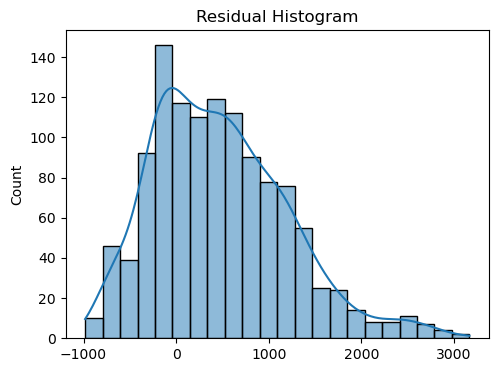

In [217]:
residuals = test['PJMW_MW'] - pred_arima
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title("Residual Histogram")

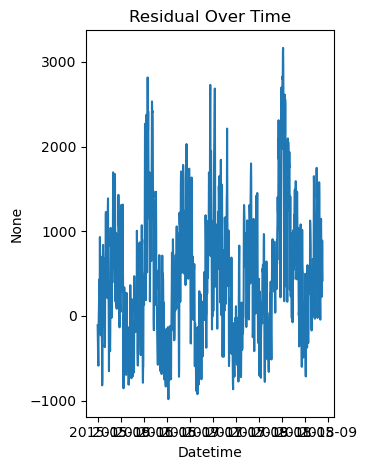

In [218]:
plt.subplot(1, 2, 2)
sns.lineplot(x=test.index, y=residuals)
plt.title("Residual Over Time")
plt.tight_layout()
plt.show()

In [219]:
import pickle
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf, f)